<SkyCoord (ICRS): (ra, dec) in deg
    (266.58818356, -28.59536026)>
(array(175.), array(166.))
Noise lower: 100.79178549403905 GHz
Noise upper: 100.81620051950901 GHz
Width: 0.024415025469963325 GHz
sigma: 0.025935414253619855 K
3 sigma: 0.07780624276085957 K


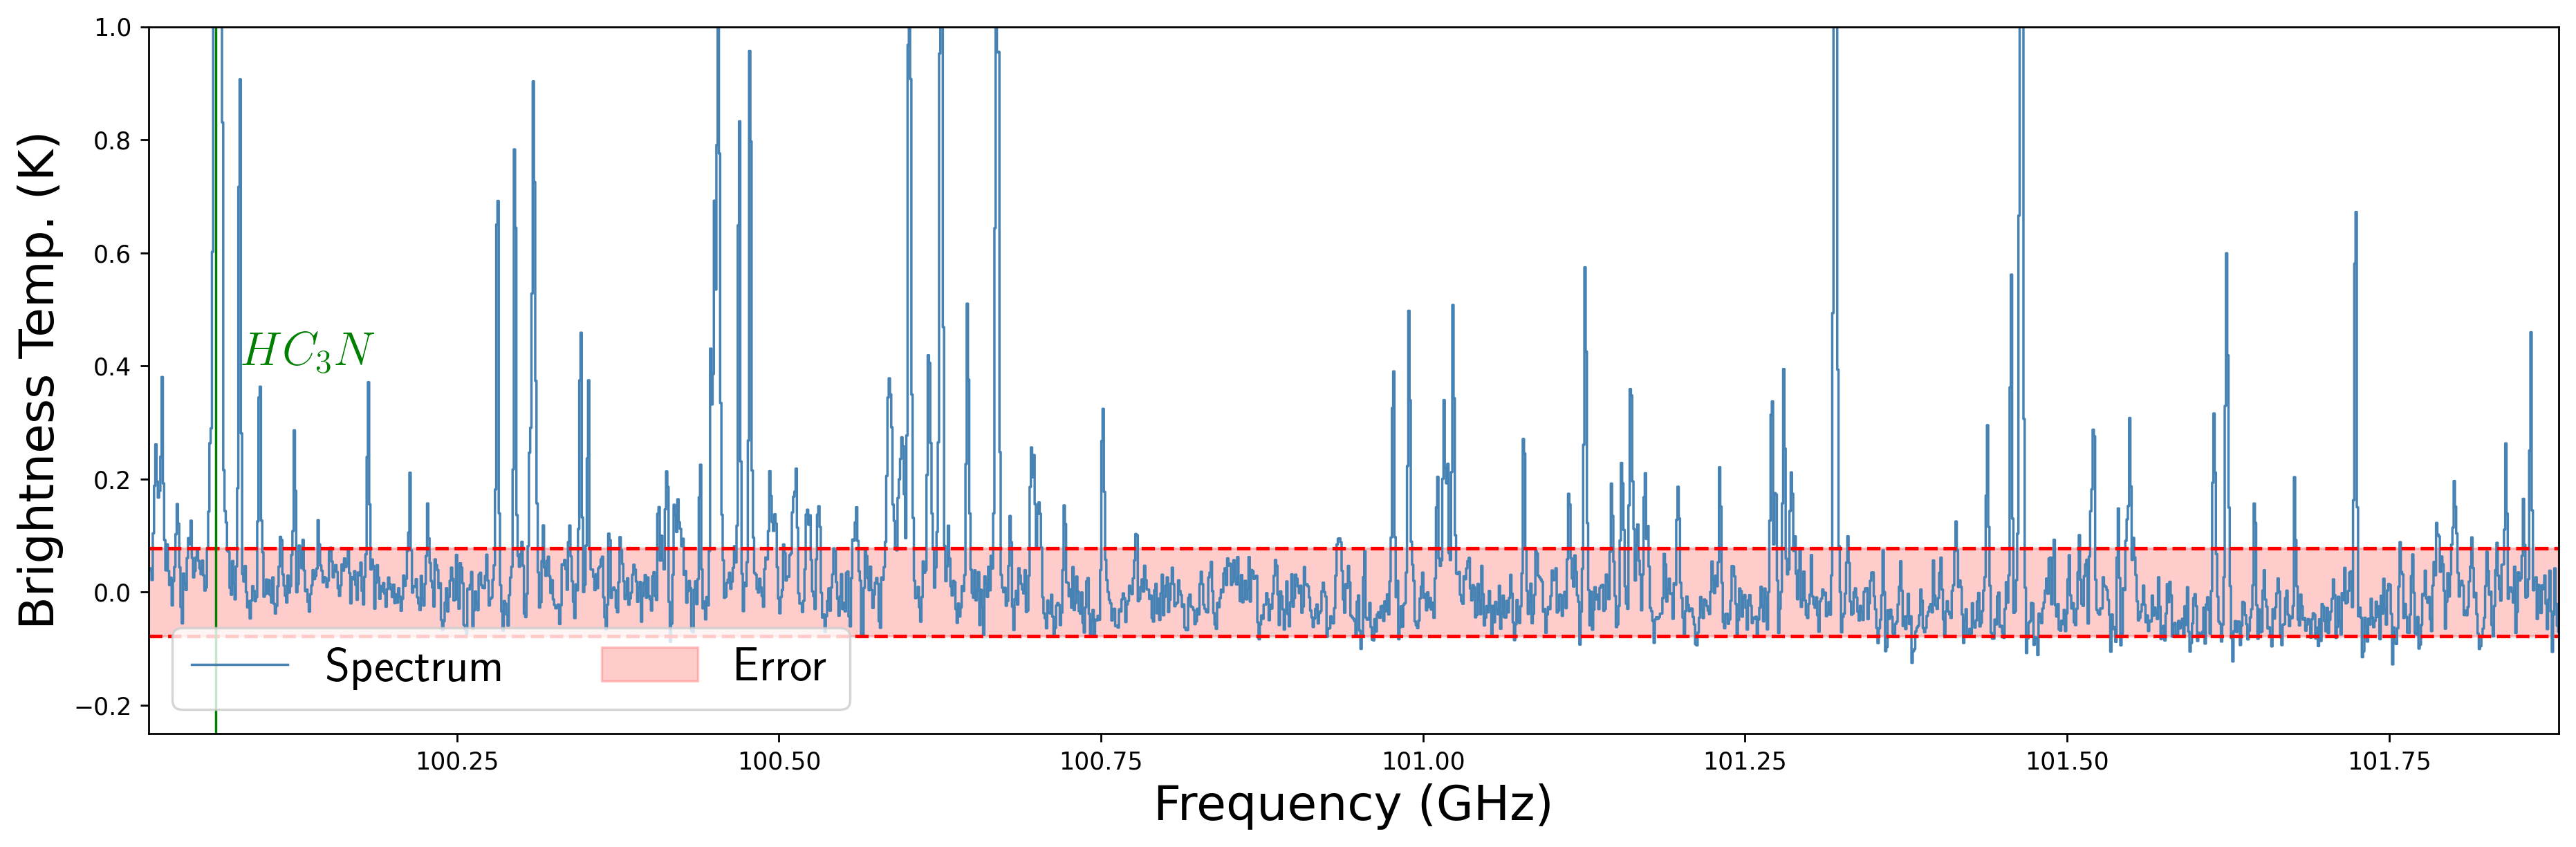

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from matplotlib.patches import Rectangle
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import numpy as np
from spectral_cube import SpectralCube
import pyspeckit
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
header=fits.getheader(path)
w1=WCS(header)
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=w1.pixel_to_world(175,166)
print(core_coords)


#########

#reads in file
path="B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits"
#makes figure
fig1=pylab.figure(1,figsize=(15,5),dpi=250)



#find the corresponding pixel positions for those coords in new image
header=fits.getheader(path)
w2=WCS(header)
image_coords=core_coords.to_pixel(w2,0,mode="wcs")
print(image_coords)

#plots spectrum
sc=SpectralCube.read(path)
sc.allow_huge_operations=True 
sc_Ghz=sc.with_spectral_unit(u.GHz)
sc_Ghz=sc_Ghz.to(u.K)
freq,Dec,Ra = sc_Ghz.world[:,0,0] 
subcube=sc_Ghz.hdu.data[:,int(image_coords[0])-5:int(image_coords[0])+5,int(image_coords[1])-5:int(image_coords[1])+5]
spectrum = np.average(subcube,axis=(1,2)) 
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue",label='Spectrum')
pylab.xlabel("Frequency (GHz)", fontsize=20)
    
pylab.ylabel('Brightness Temp. (K)',fontsize=20)
pylab.ylim(-.25,1)


plt.rcParams['text.usetex'] = True

###Noise###
Noise_upper=825
Noise_lower=800
width=freq[Noise_upper]-freq[Noise_lower]
print(f"Noise lower: {freq[Noise_lower]}")
print(f"Noise upper: {freq[Noise_upper]}")
print(f"Width: {width}")
#lower line
#pylab.vlines(freq[Noise_lower].value,-1,4,colors="black")
#upper line
#pylab.vlines(freq[Noise_upper].value,-1,4,colors="black")
#calculate 3 sigma
sigma=np.std(spectrum[Noise_lower:Noise_upper])
three_sigma=3*sigma
#three_sigma_Jy=three_sigma.to(u.jansky)
print(f"sigma: {sigma} K")
print(f"3 sigma: {three_sigma} K")
#print(f"3 sigma: {three_sigma_Jy} Jy")
pylab.hlines(three_sigma,freq[0].value,freq[1916].value,colors="red",label ='',ls="--" )
pylab.hlines(-1*three_sigma,freq[0].value,freq[1916].value,colors="red",label ='',ls="--" )

pylab.xlim(freq[0].value,freq[1916].value)
ax1.fill_between(freq.value,three_sigma, -1*three_sigma, alpha = 0.2, color= 'red' ,label='Error')

#pylab.vlines(115.256,-2,7,colors="green",label=r"${}^{12}C^{16}O$",lw=2)

molecule= 100.063
molecule_name= r'$HC_3N$'
pylab.vlines(molecule,-1,2,colors="green",label="",linewidth=1)
plt.text(molecule+.02,0.4,molecule_name,rotation='horizontal',color='green',fontsize='20') 
plt.tight_layout()
plt.legend(fontsize=20,ncols=2,loc='lower left')
#plt.title('B29',fontsize='20')
plt.savefig("B.spw29.pdf")
plt.savefig('B.spw29.png')


# Split Spectra

0 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done


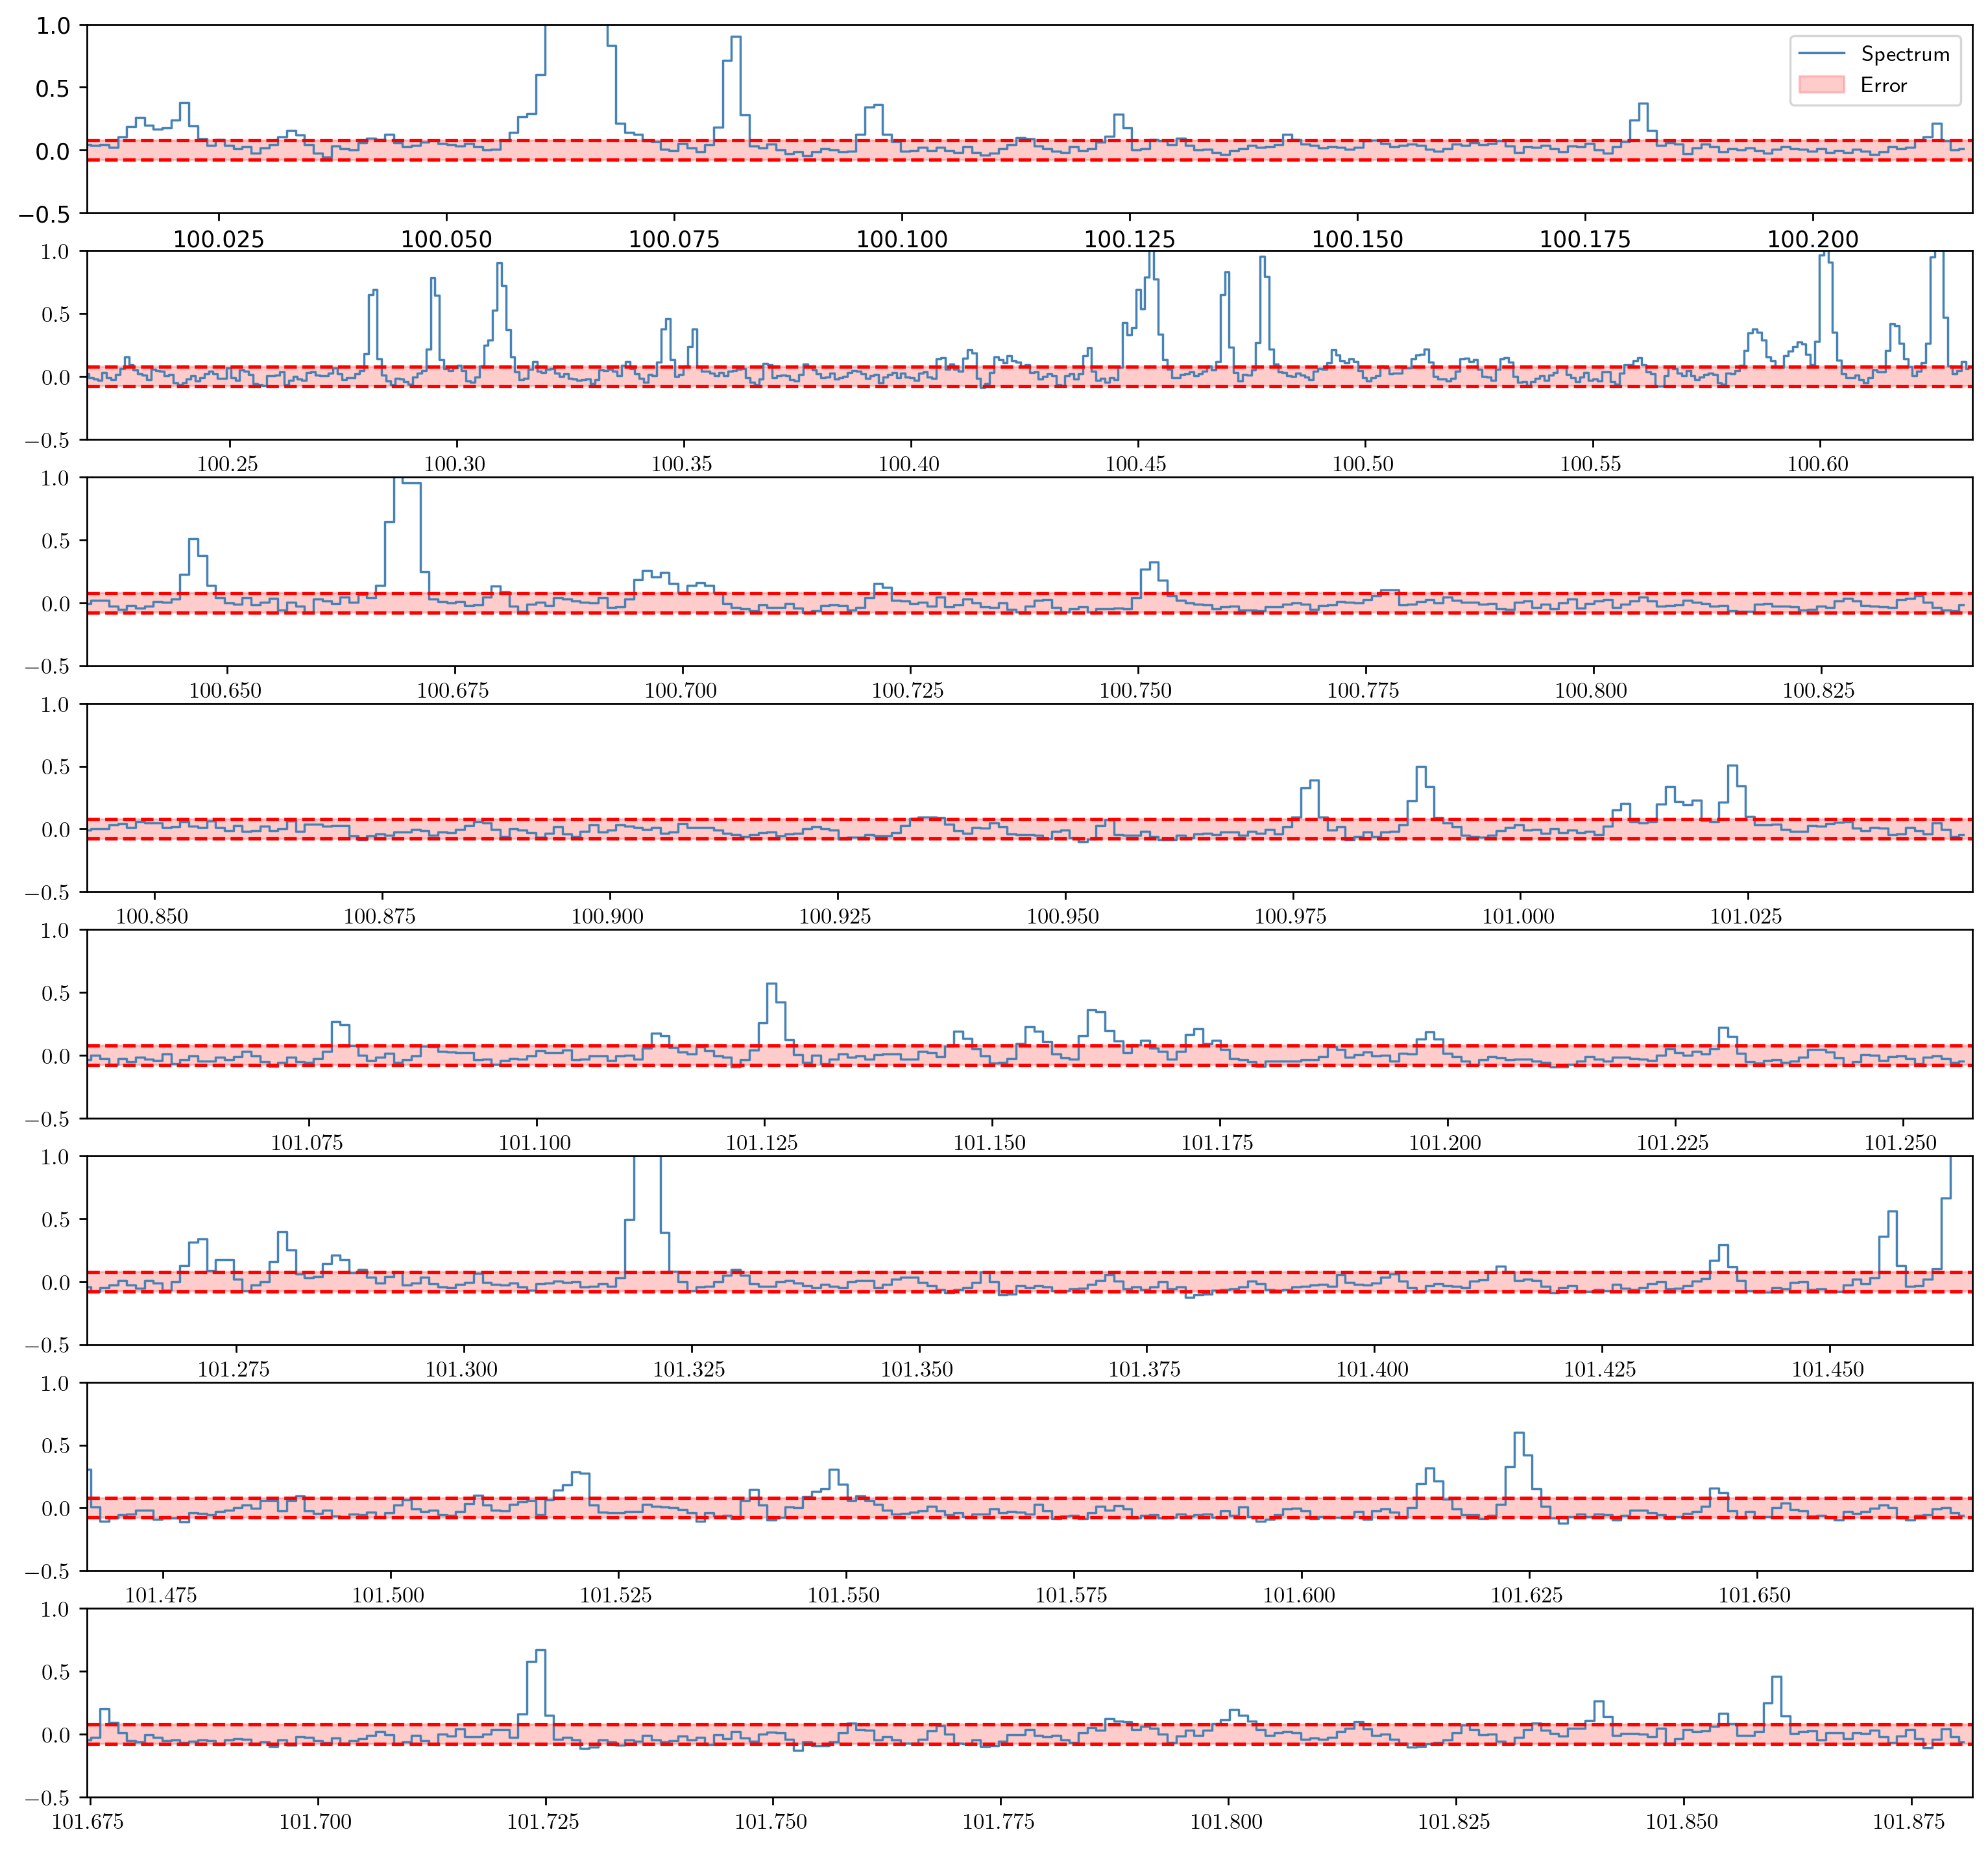

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from matplotlib.patches import Rectangle
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import numpy as np
from spectral_cube import SpectralCube     
import pyspeckit as psk
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

#where the noise is taken for each cube
Noise_measures=[
[800,825], #B29
]

#name of each subplot
plot_title=[
"B29", #B29
]

#subdivisions of the frequency range
Freq_range=[
[0,212],
[213,638],
[639,851],
[852,1064],
[1065,1277],
[1278,1490],
[1491,1703],
[1704,1916]
]

#init the figure
fig1=pylab.figure(1,figsize=(15,16),dpi=250)

#finds coords of the core
center_path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
center_header=fits.getheader(center_path)
wcenter=WCS(center_header)
wcenter = wcenter.dropaxis(3)
wcenter = wcenter.dropaxis(2)
#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=wcenter.pixel_to_world(175,166)

#plots each cube
for i in range(len(Freq_range)):
    #plotting spectrum
    path="B.Dust_Ridge_sci.spw29.cube.I.pbcor.fits"
    #find the corresponding pixel positions for those coords in new image
    header=fits.getheader(path)
    w2=WCS(header)
    image_coords=core_coords.to_pixel(w2,0,mode="wcs")
    #plots spectrum
    sc=SpectralCube.read(path)
    sc.allow_huge_operations=True 
    sc_Ghz=sc.with_spectral_unit(u.GHz)
    sc_Ghz=sc_Ghz.to(u.K)
    freq,Dec,Ra = sc_Ghz.world[:,0,0] 
    subcube=sc_Ghz.hdu.data[:,int(image_coords[0])-5:int(image_coords[0])+5,int(image_coords[1])-5:int(image_coords[1])+5]
    spectrum = np.average(subcube,axis=(1,2)) 
    ax1=pylab.subplot(9,1,i+1)
    ax1.plot(freq[Freq_range[i][0]:Freq_range[i][1]],spectrum[Freq_range[i][0]:Freq_range[i][1]],lw=1,drawstyle='steps-mid',color="SteelBlue",label="Spectrum")
    pylab.ylim(-0.5,1)
    plt.rcParams['text.usetex'] = True
    
    #calculates noise
    Noise_upper=Noise_measures[0][1]
    Noise_lower=Noise_measures[0][0]
    width=freq[Noise_upper]-freq[Noise_lower]
    #calculate 3 sigma
    sigma=np.std(spectrum[Noise_lower:Noise_upper])
    three_sigma=3*sigma
    
    #plots pm three sigma
    #freq[Freq_range[i][0]:Freq_range[i][1]]
    pylab.hlines(three_sigma,freq[Freq_range[i][0]].value,freq[Freq_range[i][1]].value,colors="red",ls="--" )
    pylab.hlines(-1*three_sigma,freq[Freq_range[i][0]].value,freq[Freq_range[i][1]].value,colors="red",ls="--" )
    pylab.xlim(freq[Freq_range[i][0]].value,freq[Freq_range[i][1]].value)
    
    if i==0:
        ax1.fill_between(freq.value,three_sigma, -1*three_sigma, alpha = 0.2, color= 'red',label="Error" )
        plt.legend()
    else:
        ax1.fill_between(freq.value,three_sigma, -1*three_sigma, alpha = 0.2, color= 'red',label="" )
    print(i,"done")
plt.savefig("B29.divided.pdf")
plt.savefig("B29.divided.png")

# Line ID

Param #0   AMPLITUDE0 =      10.6063 +/-       0.0223423 
Param #1       SHIFT0 =      100.063 +/-     2.70858e-06 
Param #2       WIDTH0 =   0.00111333 +/-     2.70737e-06   Range:   [0,inf)


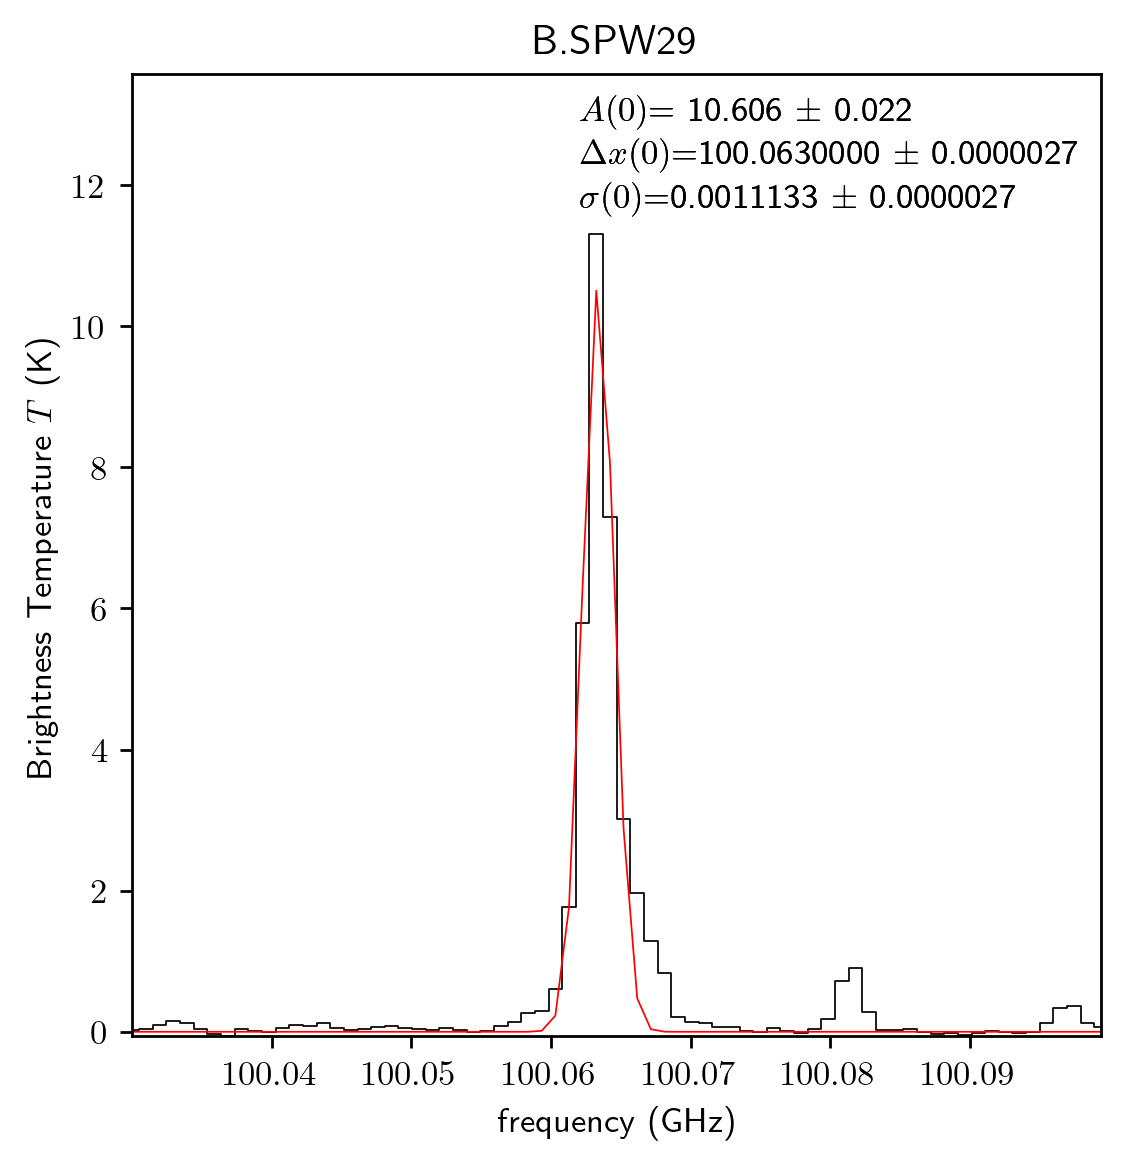

In [9]:
#Creates regions zoomed around feature
zoom = np.where((freq.value>100.03)*(freq.value<100.1))
zoom_spectrum=spectrum[zoom]
zoom_freq = freq[zoom]

#Calculates the error 
error = np.zeros(np.size(zoom))
meas = sigma #uses sigma calc from previous block
error = error + meas

#plots the gaussian fit
sp = pyspeckit.Spectrum(data=zoom_spectrum,xarr=zoom_freq,error=error,unit='K')
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1),title="B.SPW29")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('B.spw29.brightest.pdf')
sp.plotter.savefig('B.spw29.brightest.png')
print(sp.specfit.parinfo)